In [166]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            # mass = np.random.uniform(0.5, 10) # Commented to make training easier for now
            mass = 1
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 1000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.008929, y = 0.638828, mass = 1.0000, force = [9.632023e+00, 3.016130e+00]]
  Particle 2: [x = 0.294795, y = 0.787067, mass = 1.0000, force = [-8.193296e+00, -6.108596e+00]]
  Particle 3: [x = 0.459411, y = 0.040090, mass = 1.0000, force = [-1.438727e+00, 3.092465e+00]]

Data point 2:
  Particle 1: [x = 0.976826, y = 0.847451, mass = 1.0000, force = [-1.311897e+00, -1.407318e+00]]
  Particle 2: [x = 0.120088, y = 0.240578, mass = 1.0000, force = [6.276714e+00, -3.060525e+00]]
  Particle 3: [x = 0.446929, y = 0.028945, mass = 1.0000, force = [-4.964818e+00, 4.467843e+00]]

Data point 3:
  Particle 1: [x = 0.675371, y = 0.169702, mass = 1.0000, force = [-6.614413e+00, 3.917036e+00]]
  Particle 2: [x = 0.104281, y = 0.786483, mass = 1.0000, force = [2.834775e+00, -4.802605e+00]]
  Particle 3: [x = 0.321562, y = 0.349868, mass = 1.0000, force = [3.779638e+00, 8.855685e-01]]



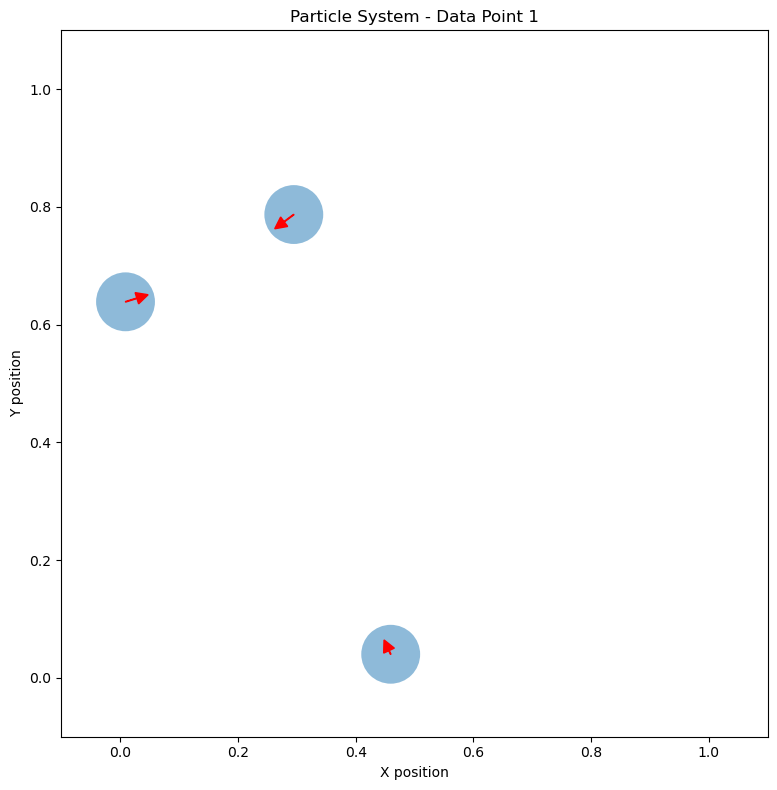

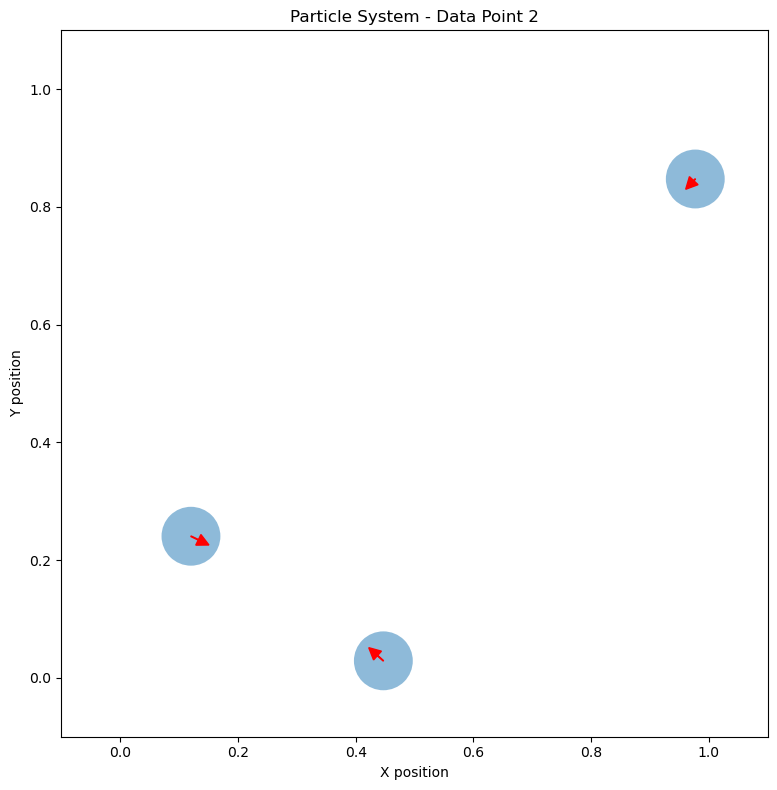

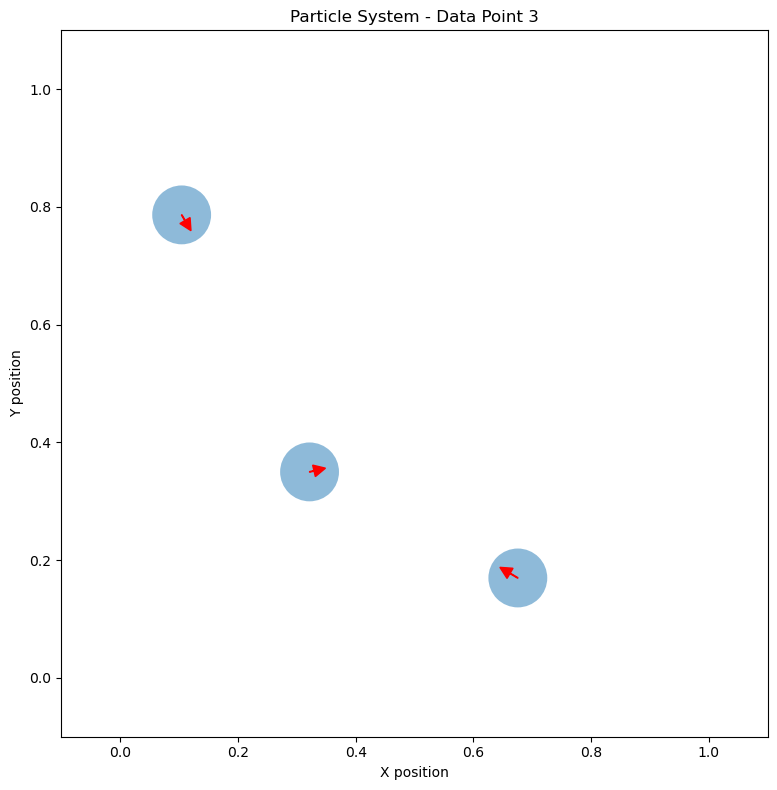

In [167]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 128),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            # nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            # nn.ReLU(),
            # nn.Linear(32, 32),
            # nn.ReLU(),
            nn.Linear(5, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.1830, 0.2370, 0.6624],
        [0.1024, 0.1552, 0.7296],
        [0.5167, 0.0388, 0.5588]])
Input:
tensor([[0.1830, 0.2370, 0.6624],
        [0.1024, 0.1552, 0.7296],
        [0.5167, 0.0388, 0.5588]])

Output (forces):
tensor([[ 0.2781, -0.0152],
        [ 0.2207,  0.0276],
        [ 0.3443, -0.1399]], grad_fn=<AddmmBackward0>)


In [169]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.00892886726807729, 0.638828061063331, 1, [9.63202299692528, 3.0161301864312997]], [0.2947951023926684, 0.7870666358075786, 1, [-8.193295948786638, -6.108595646862296]], [0.4594105457547617, 0.040090234572561445, 1, [-1.4387270481386425, 3.0924654604309962]]]
[[0.9768259462395038, 0.847450613523874, 1, [-1.311896858180669, -1.407318258986808]], [0.12008832787209656, 0.24057844050641342, 1, [6.276714406054374, -3.060524752957885]], [0.4469286250349075, 0.028944814259594942, 1, [-4.9648175478737055, 4.467843011944693]]]


tensor([[0.0089, 0.6388, 1.0000],
        [0.2948, 0.7871, 1.0000],
        [0.4594, 0.0401, 1.0000]])
tensor([[0.9768, 0.8475, 1.0000],
        [0.1201, 0.2406, 1.0000],
        [0.4469, 0.0289, 1.0000]])


tensor([[ 9.6320,  3.0161],
        [-8.1933, -6.1086],
        [-1.4387,  3.0925]])
tensor([[-1.3119, -1.4073],
        [ 6.2767, -3.0605],
        [-4.9648,  4.4678]])


Using device: cuda
Epoch [1/300], Loss: 183488.2677, Learning Rate: 0.0020000000
Epoch [2/300], Loss: 183068.5618, Learning Rate: 0.0020000000
Epoch [3/300], Loss: 183566.8542, Learning Rate: 0.0020000000
Epoch [4/300], Loss: 183188.3685, Learning Rate: 0.0020000000
Epoch [5/300], Loss: 183132.0592, Learning Rate: 0.0020000000
Epoch [6/300], Loss: 186862.7031, Learning Rate: 0.0020000000
Epoch [7/300], Loss: 183020.2971, Learning Rate: 0.0020000000
Epoch [8/300], Loss: 182805.0513, Learning Rate: 0.0020000000
Epoch [9/300], Loss: 182701.3221, Learning Rate: 0.0020000000
Epoch [10/300], Loss: 182632.3207, Learning Rate: 0.0020000000
Epoch [11/300], Loss: 183087.7107, Learning Rate: 0.0020000000
Epoch [12/300], Loss: 182356.1505, Learning Rate: 0.0020000000
Epoch [13/300], Loss: 182468.5534, Learning Rate: 0.0020000000
Epoch [14/300], Loss: 182522.0722, Learning Rate: 0.0020000000
Epoch [15/300], Loss: 182536.4474, Learning Rate: 0.0020000000
Epoch [16/300], Loss: 182360.7871, Learning R

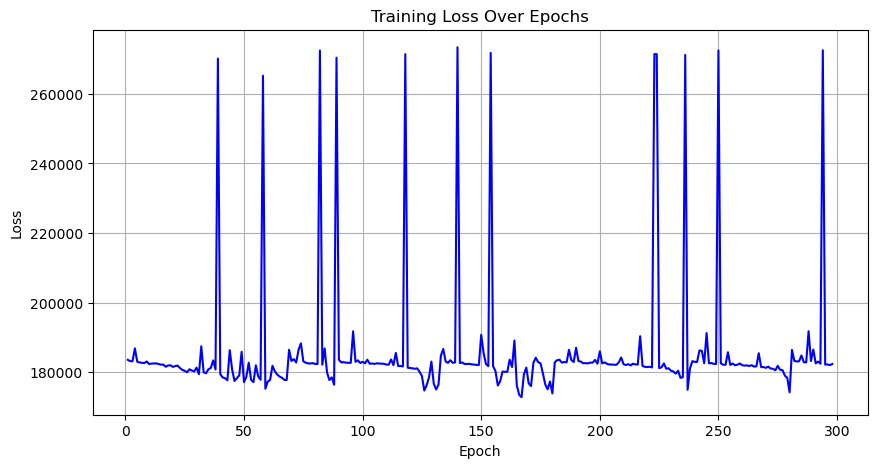

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=1)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 300  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in dataloader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs - 1), loss_values[2:], color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [171]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

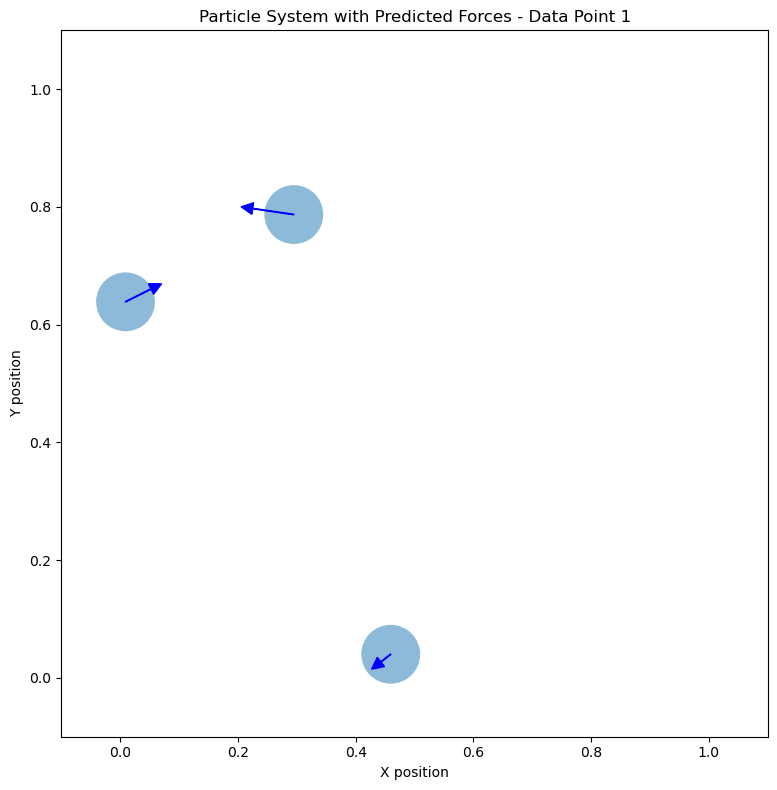

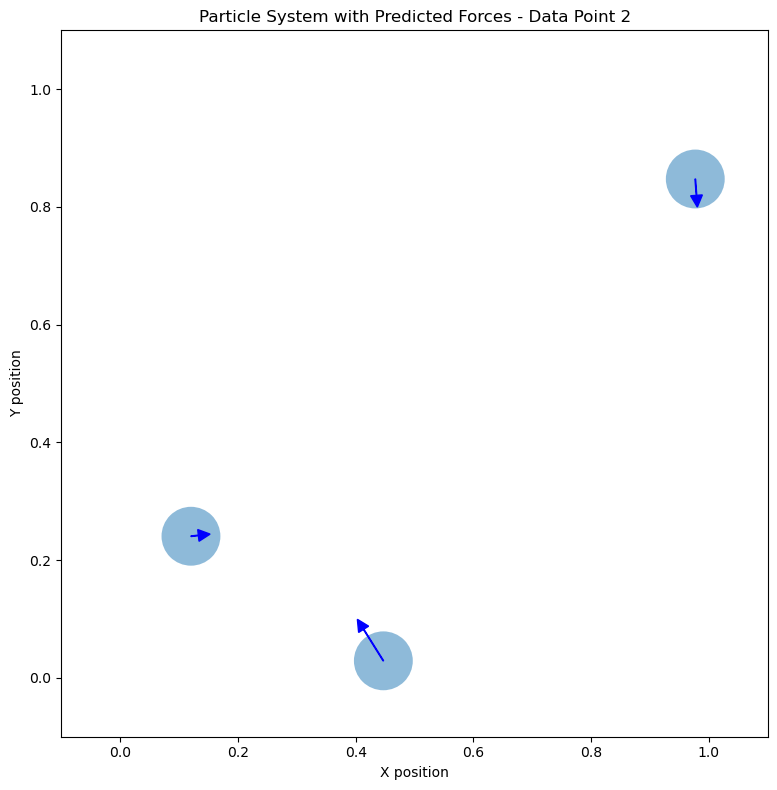

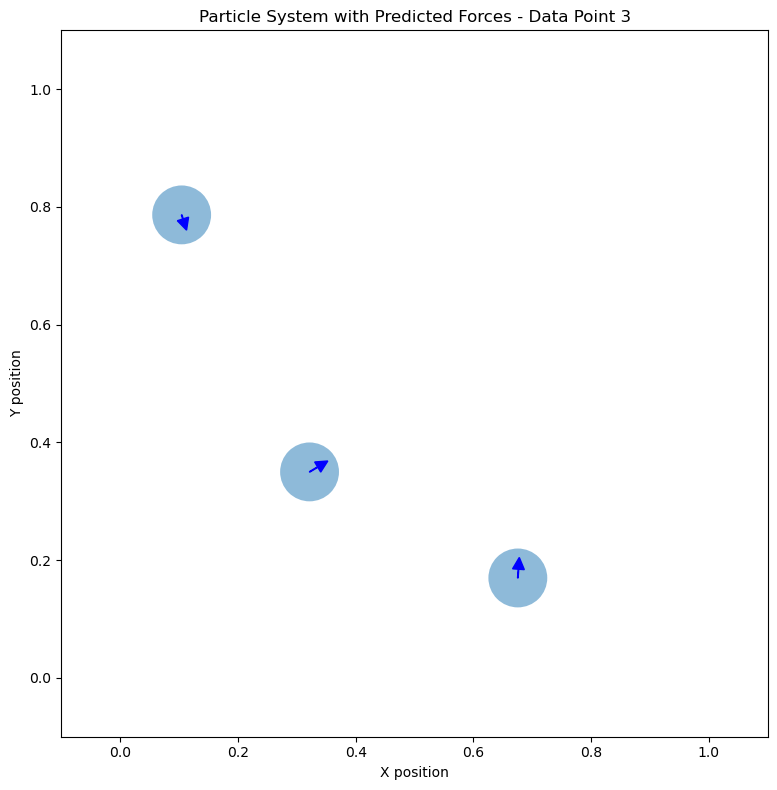

In [172]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)